In [23]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from scipy.optimize import minimize, leastsq  # for the minimizer in part 1
from mpl_toolkits.mplot3d import Axes3D

## Set up functions

In [2]:
train_pts = (np.pi/10) * np.linspace(0, 5, 6)
g = lambda x : 1 - np.cos(x)
relu = lambda x : np.maximum(x, 0)
relup = lambda x : np.where(x <= 0, 0, 1)
f = lambda a, b : ((relu(a*train_pts - b) - g(train_pts))**2).sum()/12

def gradf(a, b):
    out = np.zeros((2,))
    out[0] = (1/6)*sum((relu(a*train_pts - b) - g(train_pts))*relup(a*train_pts - b)*train_pts)
    out[1] =-(1/6)*sum((relu(a*train_pts - b) - g(train_pts))*relup(a*train_pts - b))
    return out

def hessf(a, b):
    out = np.zeros((2, 2))
    relup2 = relup(a*train_pts - b)**2
    out[0, 0] = (train_pts**2*relup2).sum()
    out[0, 1] = out[1, 0] = -(train_pts*relup2).sum()
    out[1, 1] = relup2.sum()
    return out/6

## Part 1

In [3]:
# get grad vals and f vals
a = b = np.linspace(-5, 5)
AA, BB = np.meshgrid(a, b)
f_vals = np.zeros((a.shape[0], b.shape[0]))
grad_vals = np.zeros((a.shape[0], b.shape[0], 2))
for i in range(grad_vals.shape[0]):
    for j in range(grad_vals.shape[1]):
        f_vals[i, j] = f(AA[i, j], BB[i, j])
        grad_vals[i, j, :] = gradf(AA[i, j], BB[i, j])

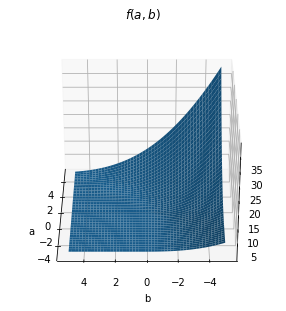

In [4]:
ax = plt.figure(figsize=(5,5)).add_subplot(111, projection='3d')
ax.plot_surface(AA, BB, f_vals)
ax.set_xlabel('a'); ax.set_ylabel('b')
ax.view_init(azim=180)
plt.title(r'$f(a,b)$')
plt.savefig('../pics/loss_surface.png')
plt.show()

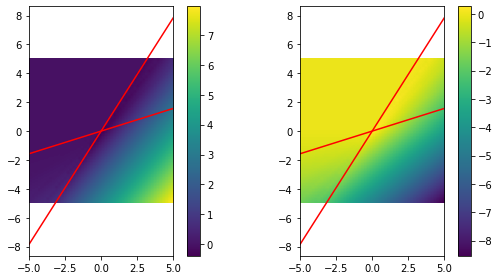

In [14]:
_, (ax1, ax2) = plt.subplots(figsize=(8, 4), ncols=2)
c1 = ax1.imshow(np.flip(grad_vals[:, :, 0], axis=0), extent=[-5,5,-5,5])
ax1.plot(a, (np.pi/2)*a, 'r')
ax1.plot(a, (np.pi/10)*a, 'r')
#ax1.scatter(m[0], m[1], c='r')
plt.colorbar(c1, ax=ax1)
c2 = ax2.imshow(np.flip(grad_vals[:, :, 1], axis=0), extent=[-5,5,-5,5])
ax2.plot(a, (np.pi/2)*a, 'r')
ax2.plot(a, (np.pi/10)*a, 'r')
#ax2.scatter(m[0], m[1], c='r')
plt.colorbar(c2, ax=ax2)
plt.tight_layout()
plt.show()

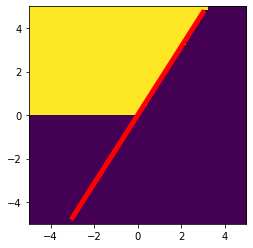

In [6]:
tol = 1e-5
zidxs = np.logical_and(abs(grad_vals[:, :, 0]) < tol, abs(grad_vals[:, :, 1]) < tol)
plt.imshow(np.flip(zidxs, axis=0), extent=[-5, 5, -5, 5])
plt.plot(np.linspace(-3, 3), (np.pi/2)*np.linspace(-3, 3), 'r', linewidth=5)
plt.savefig('../pics/flat_region.png')
plt.show()
# why is it not 0 at the minimizer?? i guess it just didn't evaluate there

In [7]:
# Find where Hessian is negative and positive definite
a = b = np.linspace(-5, 5)
AA, BB = np.meshgrid(a, b)
hess_vals = np.zeros((a.shape[0], b.shape[0], 2))
for i in range(hess_vals.shape[0]):
    for j in range(hess_vals.shape[1]):
        hess_vals[i, j, :] = np.linalg.eig(hessf(AA[i, j], BB[i, j]))[0]

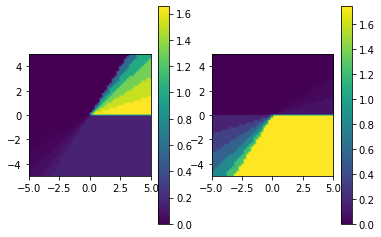

In [13]:
_, (ax1, ax2) = plt.subplots(ncols=2)
c1 = ax1.imshow(np.flip(hess_vals[:,:,0], axis=0), extent=[-5,5,-5,5])
#ax1.plot(a, -(np.pi/2)*a, 'r', a, -(np.pi/10)*a, 'r', a, -(2*np.pi/5)*a, 'r', a, -(3*np.pi/10)*a, 'r', a, -(np.pi/5)*a, 'r')
#ax1.scatter(m[0], m[1], c='r')
plt.colorbar(c1, ax=ax1)
c2 = ax2.imshow(np.flip(hess_vals[:,:,1], axis=0), extent=[-5,5,-5,5])
#ax2.scatter(m[0], m[1], c='r')
plt.colorbar(c2, ax=ax2)
plt.show()
# both eigenvalues positive ==> Hess f > 0 ==> minimizer!

In [9]:
def F(p):
    a = p[0]; b = p[1]
    out = np.zeros((train_pts.shape[0]-1,))
    for j in range(1,train_pts.shape[0]):
        out[j-1] = (relu(a*train_pts[j] - b) - g(train_pts[j]))*relup(a*train_pts[j] - b)
    return out

x = leastsq(F, [1, 0])[0]
x

array([0.86128902, 0.37349155])

## Part 2

In [17]:
# Define new function and gradient function
def f(p):
    a = p[0]; b = p[1]
    return ((relu(a*train_pts - b) - g(train_pts))**2).sum()/12

def gfun(p, I=None):
    a = p[0]; b = p[1]; 
    x = train_pts[I] if I is not None else train_pts
    return np.array([((relu(a*x - b) - g(x))*relup(a*x - b)*x).sum()/6,
                     -((relu(a*x - b) - g(x))*relup(a*x - b)).sum()/6])

In [37]:
def GD(x0, gfun, alpha=1, maxiter=int(1e6), tol=1e-7, cutoff=False):
    x = x0
    
    for iter in range(maxiter):
        xp = x
        gp = gfun(xp)
        x = xp - alpha*gp
        
        if iter > 0 and np.linalg.norm(gp) < tol: break
        if cutoff and iter > 1000: break
    if iter == maxiter: print('max iterations reached')
    return x, iter

In [39]:
x0 = np.array([1, 0])
GD(x0, gfun, alpha=1)

(array([0.86128732, 0.37348958]), 298)

In [29]:
# Compute f on this part of the plot
x1 = np.linspace(0, 1.5)
x2 = np.linspace(-0.5, 2.5)
XX, YY = np.meshgrid(x1, x2)

f_vals2 = np.zeros((x1.shape[0], x2.shape[0]))
for i in range(f_vals2.shape[0]):
    for j in range(f_vals2.shape[1]):
        f_vals2[i, j] = f([XX[i, j], YY[i, j]])

In [30]:
m = minimize(f, [1, 0]).x
m

array([0.86131324, 0.37351475])

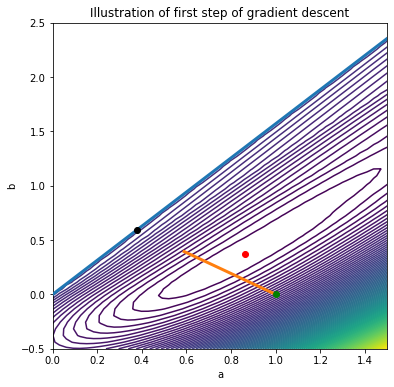

In [32]:
step = -gfun(np.array([1,0]))

_ = plt.subplots(figsize=(6,6))
plt.contour(XX, YY, f_vals2, levels=150, zorder=1)
plt.plot(x1, (np.pi/2)*x1, linewidth=3, zorder=3)
plt.plot([1, 1 + step[0]], [0, step[1]], linewidth=3, zorder=3)
plt.scatter(1, 0, c='g', zorder=4)
plt.scatter(m[0], m[1], c='r', zorder=4)
plt.scatter(intersection[0], intersection[1], c='k', zorder=4)
plt.xlabel('a')
plt.ylabel('b')
plt.title('Illustration of first step of gradient descent')
plt.savefig('../pics/gd_firststep.png')
plt.show()

In [27]:
slope = step[1]/step[0]
lhs = np.array([[slope, -1], [np.pi/2, -1]])
rhs = np.array([slope, 0])
intersection = np.linalg.solve(lhs, rhs)
intersection

array([0.37958407, 0.59624926])

In [35]:
d = np.sqrt((intersection[0] - 1)**2 + intersection[1]**2)
astar = d/np.linalg.norm(step)
astar

1.5099602410260964

In [43]:
alphas = astar*np.linspace(0.8, 0.9, num=40)
results = np.zeros(alphas.shape)
for i in range(results.shape[0]):
    _, indicator = GD(x0, gfun, alpha=alphas[i], cutoff=True)
    results[i] = 1 if indicator > 1000 else 0
    

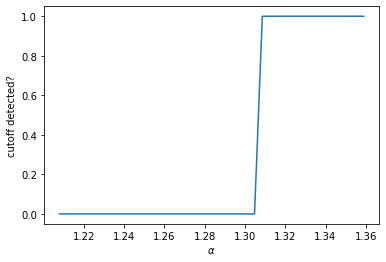

In [45]:
plt.plot(alphas, results)
plt.xlabel(r'$\alpha$')
plt.ylabel('cutoff detected?')
plt.savefig('../pics/cutoffs.png')
plt.show()

## Part 3

In [464]:
def SGD(x0, gfun, schedule='recip', maxiter=250, lr=astar*0.8, r=0.95**(-1), M=None):
    # Stochastic gradient descent function with batch size 1
    # Input: x0   = initial guess
    #        gfun = gradient of function accepting index to report at

    x = x0
    n = train_pts.shape[0]
    iterpts = iterrange = range(maxiter)

    # Create stepped array
    if M is not None: iterpts = [iter // M for iter in iterrange]

    # Set stepsize reduction strategy
    if schedule == 'recip':
        alpha = [lr/(iter + 1) for iter in iterpts]
    elif schedule == 'time':
        alpha = np.zeros((maxiter,)); alpha[0] = lr
        for iter in range(1, maxiter): alpha[iter] = alpha[iter-1]/(1 + r*iter)
    elif schedule == 'exp':
        alpha = [lr*np.exp(-r*iter) for iter in iterpts]
    elif schedule == 'cons':
        alpha = [lr for iter in iterrange]
    else: raise RuntimeError('unimplemented scheduler')

    gnorms = []
    for iter in iterrange:
        xp = x
        idx = np.random.randint(0, n)  # generate random batch
        gp = gfun(xp, I=idx)
        x = xp - alpha[iter]*gp

        error = np.linalg.norm(x - m)
        gnorm = np.linalg.norm(gp)
        gnorms.append(gnorm)
    
    return x, gnorms

In [492]:
# My training routine -- change the parameters in the SGD call
x0 = np.array([1, 0])
schedule_res = dict.fromkeys(['recip', 'time', 'exp', 'cons'])
schedule_gnorms = dict.fromkeys(['recip', 'time', 'exp', 'cons'])
for schedule in schedule_res:
    x, gnorms = SGD(x0, gfun, schedule=schedule, lr=1.6, r=0.1, maxiter=500, M=40)
    schedule_res[schedule] = x
    schedule_gnorms[schedule] = gnorms
    print(f'schedule = {schedule}, x = {x}, error = {np.linalg.norm(x - m)}')

schedule = recip, x = [0.80596436 0.31303593], error = 0.0819828384819623
schedule = time, x = [0.80747649 0.24981609], error = 0.13490646342352736
schedule = exp, x = [0.85753655 0.36658306], error = 0.007893775277076676
schedule = cons, x = [0.86439061 0.35997524], error = 0.013884828420244586


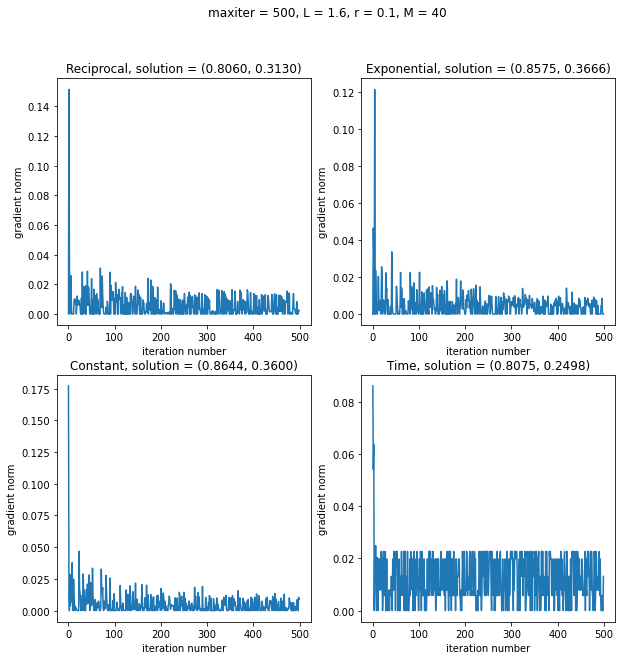

In [494]:
_, axes = plt.subplots(figsize=(10, 10), ncols=2, nrows=2)

schedule = 'recip'
axes[0,0].plot(schedule_gnorms[schedule])
axes[0,0].set_xlabel('iteration number')
axes[0,0].set_ylabel('gradient norm')
axes[0,0].set_title(f'Reciprocal, solution = ({"%.4f" % schedule_res[schedule][0]}, {"%.4f" % schedule_res[schedule][1]})')

schedule = 'exp'
axes[0,1].plot(schedule_gnorms[schedule])
axes[0,1].set_xlabel('iteration number')
axes[0,1].set_ylabel('gradient norm')
axes[0,1].set_title(f'Exponential, solution = ({"%.4f" % schedule_res[schedule][0]}, {"%.4f" % schedule_res[schedule][1]})')

schedule = 'cons'
axes[1,0].plot(schedule_gnorms[schedule])
axes[1,0].set_xlabel('iteration number')
axes[1,0].set_ylabel('gradient norm')
axes[1,0].set_title(f'Constant, solution = ({"%.4f" % schedule_res[schedule][0]}, {"%.4f" % schedule_res[schedule][1]})')

schedule = 'time'
axes[1,1].plot(schedule_gnorms[schedule])
axes[1,1].set_xlabel('iteration number')
axes[1,1].set_ylabel('gradient norm')
axes[1,1].set_title(f'Time, solution = ({"%.4f" % schedule_res[schedule][0]}, {"%.4f" % schedule_res[schedule][1]})')

plt.suptitle(f'maxiter = {500}, L = {1.6}, r = {0.1}, M = {40}')
plt.savefig(f'../pics/schedules.png')
plt.show()

## PyTorch version to check my answers

In [406]:
import torch
import torch.nn as nn
from torch.optim import SGD as tSGD

In [350]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.sigma = nn.ReLU()
        self.z = nn.Linear(1, 1)
        
    def forward(self, x):
        return self.sigma(self.z(x))

In [407]:
x_tens = torch.from_numpy(train_pts)

# Main training function
def train(x_tens, nepochs=100, delta=1e-6, lr=0.1):
    net = Net().double()
    net.zero_grad()
    criterion = nn.MSELoss()
    optimizer = tSGD(net.parameters(), lr=lr)

    for epoc in range(nepochs):
        batch = x_tens[np.random.randint(0, 6)].reshape(-1, 1)
        optimizer.zero_grad()

        output = net(batch)  # forward
        loss = criterion(output, g(batch))
        loss.backward()  # backward
        optimizer.step()  # optimize        
    
    return net

In [416]:
net = train(x_tens, lr=0.1, nepochs=500)  # does not always converge at this lr!

In [417]:
# View parameters and compute prediction of the network
for parameter in net.parameters(): print(parameter)

outputs = np.zeros(x_tens.shape)
for i in range(x_tens.shape[0]): outputs[i] = net(x_tens[i].reshape(-1, 1))

Parameter containing:
tensor([[0.8551]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([-0.3668], dtype=torch.float64, requires_grad=True)


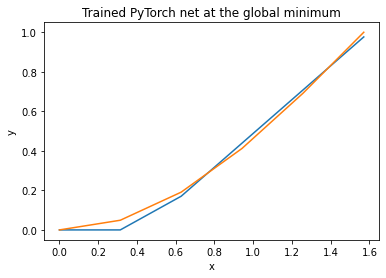

In [471]:
plt.title('Trained PyTorch net at the global minimum')
plt.plot(train_pts, outputs)
plt.plot(train_pts, g(train_pts))
plt.xlabel('x'); plt.ylabel('y')
plt.show()